In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

def load_and_process_images(path_dir, class_labels, target_num_images):
    images = []
    labels = []
    min_images = float('inf')
    class_images = {}

    for label, class_name in enumerate(class_labels):
        class_dir = os.path.join(path_dir, class_name)
        class_images[class_name] = []

        if not os.path.exists(class_dir):
            print(f"Directory '{class_name}' not found in '{path_dir}'. Skipping...")
            continue

        for jpg in os.listdir(class_dir):
            image_path = os.path.join(class_dir, jpg)
            image_high_resolution = cv2.imread(image_path)

            if image_high_resolution is None:
                print(f"Could not read image '{jpg}' in '{class_name}' directory. Skipping...")
                continue

            image_change_color = cv2.cvtColor(image_high_resolution, cv2.COLOR_BGR2RGB)
            image_low_resolution = cv2.resize(image_change_color, (256, 256))
            class_images[class_name].append(image_low_resolution)
            min_images = min(min_images, len(class_images[class_name]))
        print(f"Class '{class_name}' has {len(class_images[class_name])} images.")

    for class_name, images_list in class_images.items():
        images.extend(images_list[:target_num_images])
        labels.extend([class_name] * min(len(images_list), target_num_images))

    return np.asarray(images), np.asarray(labels)

dataset_directory = '/Datasets/DataImages/'
class_labels = ['Catla', 'Cyprinus carpio', 'Grass Carp', 'Mori', 'Rohu', 'Silver']
target_num_images = 50

# Load and preprocess data
images, labels = load_and_process_images(dataset_directory, class_labels, target_num_images)

# Split data into train and test sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Constants
BATCH_SIZE = 64
TAU = 0.1
EPOCHS = 10

# Image shape
IMG_SHAPE = (256, 256, 3)

# Define data augmentation function
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

# Define the SIMCLR model
def get_simclr_model(input_shape, temperature=0.1):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    h = base_model(x, training=True)
    z = layers.GlobalAveragePooling2D()(h)

    projection = models.Sequential([
        layers.InputLayer(input_shape=(z.shape[1],)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu')
    ], name='projection_head')

    z_projection = projection(z)

    simclr_model = models.Model(inputs, z_projection, name='simclr_model')
    return simclr_model


Class 'Catla' has 20 images.
Class 'Cyprinus carpio' has 50 images.
Class 'Grass Carp' has 11 images.
Class 'Mori' has 70 images.
Class 'Rohu' has 73 images.
Class 'Silver' has 47 images.


In [3]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integer labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# Compile the model with the custom contrastive loss function and gradient clipping
optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)  # You can adjust the clipnorm value
simclr_model = get_simclr_model(IMG_SHAPE, temperature=TAU)
simclr_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train the model
simclr_model.fit(images_train, labels_train_encoded, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(images_test, labels_test_encoded))

# Evaluate the model on test data
test_loss = simclr_model.evaluate(images_test, labels_test_encoded)
print(f'Test Loss: {test_loss}')


Epoch 1/10
3/3 [==============================] - 94s 25s/step - loss: 5.4591 - val_loss: 3.9790
Epoch 2/10
3/3 [==============================] - 73s 24s/step - loss: 3.7642 - val_loss: 2.3633
Epoch 3/10
3/3 [==============================] - 76s 25s/step - loss: 3.1200 - val_loss: 2.1719
Epoch 4/10
3/3 [==============================] - 75s 25s/step - loss: 2.3152 - val_loss: 2.1279
Epoch 5/10
3/3 [==============================] - 79s 27s/step - loss: 1.6676 - val_loss: 1.6655
Epoch 6/10
3/3 [==============================] - 75s 25s/step - loss: 1.4101 - val_loss: 1.4058
Epoch 7/10
3/3 [==============================] - 80s 28s/step - loss: 1.1296 - val_loss: 1.7553
Epoch 8/10
3/3 [==============================] - 74s 25s/step - loss: 1.1701 - val_loss: 1.1938
Epoch 9/10
3/3 [==============================] - 74s 24s/step - loss: 1.0335 - val_loss: 1.3698
Epoch 10/10
2/2 [==============================] - 5s 1s/step - loss: 1.1159
Test Loss: 1.1158559322357178


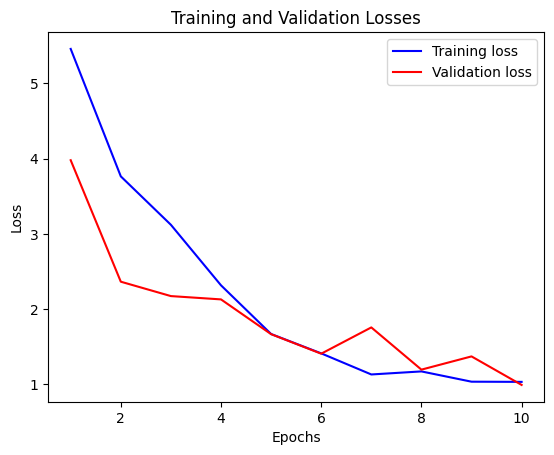

In [4]:
import matplotlib.pyplot as plt

# Define the losses
train_losses = [5.4591, 3.7642, 3.1200, 2.3152, 1.6676, 1.4101, 1.1296, 1.1701, 1.0335, 1.0310]
val_losses = [3.9790, 2.3633, 2.1719, 2.1279, 1.6655, 1.4058, 1.7553, 1.1938, 1.3698, 0.9905]
epochs = range(1, len(train_losses) + 1)

# Plot the losses
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
